# GUI

In [2]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import GridspecLayout, Label, FloatText, HTMLMath
from ipywidgets import interactive_output, fixed

from translocation_model import TranslocationModel

In [3]:
def update_model_parameters(
        models: TranslocationModel | list[TranslocationModel],
        **kwargs,
) -> None:
    """Update the parameters of the given model(s).

    Typically called by an interactive_output widget:
    interactive_output(update_model_parameters, 
                       {'models': fixed(models), 
                       **parameters})
    where parameters is a dictionary {parameter_name: parameter_widget}.
    The parameters key must match the name of the corresponding parameters in 
    the model.

    Args:
        models: A TranslocationModel or a list of TranslocationModels.
        kwargs: A dictionary {parameter_name: parameter_value} of parameters to
            update.
    """
    if isinstance(models, TranslocationModel):
        models = [models]
    for model in models:
        for key, value in kwargs.items():
            if key in vars(model):
                setattr(model, key, value)

def add_parameter(
        grid: GridspecLayout,
        row: int,
        col: int,
        symbol: str,
        desc: str,
        value: float = 1.0,
        is_constrained: bool = False
) -> None:
    """Add a parameter to the given grid.

    The parameter has a symbol, a value, and a description. If the parameter is
    not constrained, the value is a FloatText widget. If the parameter is
    constrained, the value is a Label widget.

    Args:
        grid: A GridspecLayout.
        row: The row to add the parameter to.
        col: The column to add the parameter to.
        symbol: The LaTeX symbol of the parameter.
        desc: A description of the parameter.
        value: The initial value of the parameter.
        is_constrained: Whether the parameter is constrained by other parameters
            in the model. If yes, the parameter is displayed as a label rather
            than a float text.
    """
    if is_constrained:
        parameter = Label(value=str(value))
    else:
        parameter = FloatText(value=value)
    grid[row, col] = HTMLMath(value=symbol)
    grid[row, col+1] = parameter
    grid[row, col+2] = Label(value=desc)
    return parameter
        
def add_general_parameters(
        grid: GridspecLayout, 
        parameters: dict[str, FloatText | Label],
        row: int = 0, 
        col: int = 0
):
    """Add write/read interface for general parameters to the given grid.

    Add inplace the parameters to the given grid and the {symbol: widget_value} 
    parameters dictionary.
    
    The grid is a 9x3 grid of widgets starting at the given row and column and
    expanding downwards and to the right. Each parameter row contains a symbol, 
    a value, and a description. 
    The rows are:
    0: "General physical parameters"
    1: ATP/ADP concentration ratio (ATP_ADP_ratio)
    2: Equilibrium ATP/ADP concentration ratio (equilibrium_ATP_ADP_ratio)
    3: Protomer-ATP dissociation constant (K_d_ATP)
    4: Protomer-ADP dissociation constant (K_d_ADP)
    5: Effective ADP->ATP exchange rate (k_DT)
    6: Effective ATP->ADP exchange rate (k_TD) (constrained by ATP<->ADP 
        exchange model)
    7: ATP hydrolysis rate (k_h)
    8: ATP synthesis rate (k_s)
    """
    grid[row, col] = Label(value="General Physical Parameters")

    ATP_ADP_ratio = add_parameter(
        grid, row + 1, col, r"\frac{[\text{ATP}]}{[\text{ADP}]}", 
        "ATP/ADP concentration ratio")
    
    equilibrium_ATP_ADP_ratio = add_parameter(
        grid, row + 2, col, 
        r"\frac{[\text{ATP}]}{[\text{ADP}]}\Bigr|_\text{eq.}", 
        "Equilibrium ATP/ADP concentration ratio")
    
    K_d_ATP = add_parameter(
        grid, row + 3, col, r"K_d^\text{ATP}", 
        "Protomer-ATP dissociation constant")
    
    K_d_ADP = add_parameter(
        grid, row + 4, col, r"K_d^\text{ADP}", 
        "Protomer-ADP dissociation constant")
    
    k_DT = add_parameter(
        grid, row + 5, col, r"k_{DT}", "Effective ADP->ATP exchange rate")
    
    def compute_k_TD():
        return k_DT.value * K_d_ATP.value / K_d_ADP.value / ATP_ADP_ratio.value
    k_TD = add_parameter(
        grid, row + 6, col, r"k_{TD}", 
        "Effective ATP->ADP exchange rate (constrained by ATP<->ADP exchange "\
            "model)",
        value=compute_k_TD(), is_constrained=True)
    def change_k_TD(_): 
        k_TD.value = str(compute_k_TD())
    k_DT.observe(change_k_TD, names='value')
    K_d_ATP.observe(change_k_TD, names='value')
    K_d_ADP.observe(change_k_TD, names='value')
    ATP_ADP_ratio.observe(change_k_TD, names='value')

    k_h = add_parameter(grid, row + 7, col, r"k_h", "ATP hydrolysis rate")

    k_s = add_parameter(grid, row + 8, col, r"k_s", "ATP synthesis rate")

    parameters.update({
        "ATP_ADP_ratio": ATP_ADP_ratio,
        "equilibrium_ATP_ADP_ratio": equilibrium_ATP_ADP_ratio,
        "K_d_ATP": K_d_ATP,
        "K_d_ADP": K_d_ADP,
        "k_DT": k_DT,
        "k_TD": k_TD,
        "k_h": k_h,
        "k_s": k_s,
    })


In [4]:
def add_SC2R_parameters(
        grid: GridspecLayout, 
        parameters: dict[str, FloatText | Label],
        row: int = 0, 
        col: int = 0
) -> dict[str, FloatText | Label]:
    """Add write/read interface for SC2R parameters to the given grid.

    Add inplace the parameters to the given grid and the {symbol: widget_value}
    parameters dictionary.

    The parameters dictionary must contain the general parameters.

    The gris is a 3x3 grid of widgets starting at the given row and column and
    expanding downwards and to the right. Each parameter row contains a symbol, 
    a value, and a description.
    The rows are:
    0: "SC2R parameters"
    1: Translocation up rate (k_up)
    2: Translocation down rate (k_down) (constrained by the detailed balance)
    """
    grid[row, col] = Label(
        value="Sequential Clockwise/2-Residue Step Model Physical Parameters")
    
    k_up = add_parameter(
        grid, row + 1, col, r"k_\uparrow", "Translocation up rate")
    
    def compute_k_down():
        return (
            parameters["k_h"].value * k_up.value * parameters["k_DT"].value
            / (parameters["k_s"].value * float(parameters["k_TD"].value)) # Because k_TD is a Label
            * (parameters["equilibrium_ATP_ADP_ratio"].value 
               / parameters["ATP_ADP_ratio"].value)
        )
    k_down = add_parameter(
        grid, row + 2, col, r"k_\downarrow", 
        "Translocation down rate (constrained by the detailed balance)",
        value=compute_k_down(), is_constrained=True)
    def change_k_down(_):
        k_down.value = str(compute_k_down())
    k_up.observe(change_k_down, names='value')
    parameters['ATP_ADP_ratio'].observe(change_k_down, names='value')
    parameters['equilibrium_ATP_ADP_ratio'].observe(change_k_down, 
                                                    names='value')
    parameters['k_h'].observe(change_k_down, names='value')
    parameters['k_s'].observe(change_k_down, names='value')
    parameters['k_DT'].observe(change_k_down, names='value')

    parameters.update({
        "k_up": k_up,
        "k_down": k_down,
    })

In [5]:
def add_disc_spiral_parameters(
    grid: GridspecLayout,
    parameters: dict[str, FloatText | Label],
    row: int = 0,
    col: int = 0
) -> dict[str, FloatText | Label]:
    """Add write/read interface for Disc-Spiral parameters to the given grid.

    Add inplace the parameters to the given grid and the {symbol: widget_value}
    parameters dictionary.

    The parameters dictionary must contain the general parameters.

    The gris is a 8x3 grid of widgets starting at the given row and column and
    expanding downwards and to the right. Each parameter row contains a symbol, 
    a value, and a description.
    The rows are:
    k_[extended/flat]_to_[flat/extended]_[up/down]
    0: "Disc-Spiral Model"
    1: Number of protomers (n_protomers)
    2: Effective ATP hydrolysis rate (k_h_bar)
    3: Spiral->disc up translocation rate (k_extended_to_flat_up)
    4: Disc->spiral down translocation rate (k_flat_to_extended_down)
    5: Effective disc->spiral down translocation rate (k_flat_to_extended_down_bar)
    6: Disc->spiral up translocation rate (k_flat_to_extended_up)
    7: Spiral->disc down translocation rate (k_extended_to_flat_down) (
        constrained by the detailed balance)
    """
    grid[row, col] = Label(
        value="Disc-Spiral Model Physical Parameters")
    
    n_protomers = add_parameter(
        grid, row + 1, col, r"n_\text{protomers}", "Number of protomers")
    
    def compute_k_h_bar(): 
        return n_protomers.value * parameters["k_h"].value
    k_h_bar = add_parameter(
        grid, row + 2, col, r"\bar{k}_h", "Effective ATP hydrolysis rate", 
        value=compute_k_h_bar(), is_constrained=True)
    def change_k_h_bar(_):
        k_h_bar.value = str(compute_k_h_bar())
    n_protomers.observe(change_k_h_bar, names='value')
    parameters['k_h'].observe(change_k_h_bar, names='value')

    k_extended_to_flat_up = add_parameter(
        grid, row + 3, col, r"k_↱", "Spiral->disc up translocation rate")
    
    k_flat_to_extended_down = add_parameter(
        grid, row + 4, col, r"k_⤵", "Disc->spiral down translocation rate")
    
    def compute_k_flat_to_extended_down_bar():
        return n_protomers.value * k_flat_to_extended_down.value
    k_flat_to_extended_down_bar = add_parameter(
        grid, row + 5, col, r"\bar{k}_⤵", 
        "Effective disc->spiral down translocation rate", 
        value=compute_k_flat_to_extended_down_bar(), is_constrained=True)
    def change_k_flat_to_extended_down_bar(_):
        k_flat_to_extended_down_bar.value = str(
            compute_k_flat_to_extended_down_bar())
    n_protomers.observe(change_k_flat_to_extended_down_bar, names='value')
    k_flat_to_extended_down.observe(change_k_flat_to_extended_down_bar,
                                    names='value')

    k_flat_to_extended_up = add_parameter(
        grid, row + 6, col, r"k_⤴", "Disc->spiral up translocation rate")
    
    def compute_k_extended_to_flat_down():
        return ((parameters["k_h"].value * k_flat_to_extended_up.value 
                 * parameters["k_DT"].value * k_extended_to_flat_up.value)
                / (parameters["k_s"].value * float(parameters["k_TD"].value) 
                   * k_flat_to_extended_down.value)
                * (parameters["equilibrium_ATP_ADP_ratio"].value 
                   / parameters["ATP_ADP_ratio"].value))
    k_extended_to_flat_down = add_parameter(
        grid, row + 7, col, r"k_↳", 
        "Spiral->disc down translocation rate (constrained by the detailed "\
            "balance)",
        value=compute_k_extended_to_flat_down(), is_constrained=True)
    def change_k_extended_to_flat_down(_):
        k_extended_to_flat_down.value = str(compute_k_extended_to_flat_down())
    parameters['k_h'].observe(change_k_extended_to_flat_down, names='value')
    parameters['k_s'].observe(change_k_extended_to_flat_down, names='value')
    parameters['k_DT'].observe(change_k_extended_to_flat_down, names='value')
    k_extended_to_flat_up.observe(change_k_extended_to_flat_down, names='value')
    k_flat_to_extended_down.observe(change_k_extended_to_flat_down,
                                    names='value')
    k_flat_to_extended_up.observe(change_k_extended_to_flat_down, names='value')
    parameters['ATP_ADP_ratio'].observe(change_k_extended_to_flat_down, 
                                        names='value')
    parameters['equilibrium_ATP_ADP_ratio'].observe(
        change_k_extended_to_flat_down, names='value')
    
    parameters.update({
        "n_protomers": n_protomers,
        "k_h_bar": k_h_bar,
        "k_extended_to_flat_up": k_extended_to_flat_up,
        "k_flat_to_extended_down": k_flat_to_extended_down,
        "k_flat_to_extended_down_bar": k_flat_to_extended_down_bar,
        "k_flat_to_extended_up": k_flat_to_extended_up,
        "k_extended_to_flat_down": k_extended_to_flat_down,
    })
    

In [11]:
gui = GridspecLayout(20, 3)
parameters = {}
add_general_parameters(gui, parameters)
add_SC2R_parameters(gui, parameters, row=9)
add_disc_spiral_parameters(gui, parameters, row=12)
display(gui)

GridspecLayout(children=(Label(value='General Physical Parameters', layout=Layout(grid_area='widget001')), HTM…

# Test interactive plot

In [9]:
from translocation_model import SC2R1Loop
import matplotlib.pyplot as plt

In [ ]:
sc2r = SC2R1Loop()
def interactive_trajectory(
    model: TranslocationModel,
    physical_parameters: dict[str, FloatText | Label],

):
    update_model_parameters(model, physical_parameters)
    trajectory = model.gillespie(cumulative_sums='position')
    ax = model.plot_position_evolution(
        trajectory, r"$1/k_\uparrow$"
    )
    plt.show()

out = interactive_output(
    interactive_trajectory,
    {
        'model': fixed(SC2R1Loop()),
        
)

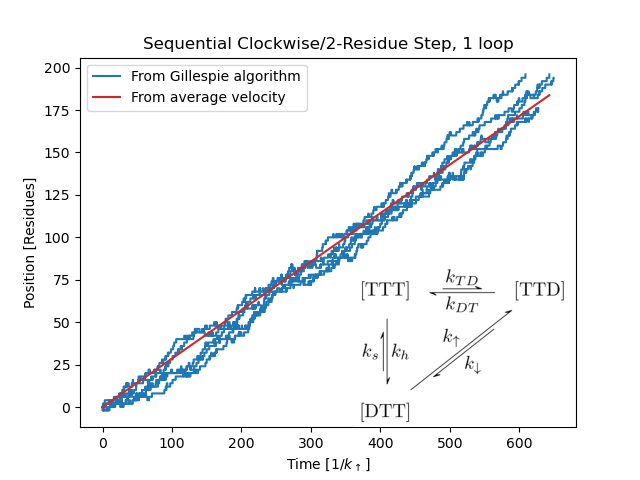

In [10]:
SC_2R_1_loop = SC2R1Loop()
trajectories = SC_2R_1_loop.gillespie(n_simulations=5, 
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_1_loop.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)
plt.show()

# Imports

In [1]:
%matplotlib widget

In [2]:
from translocation_model import (SC2R1Loop, SC2R2Loops, DiscSpiral, 
                                 DefectiveSC2R, DefectiveDiscSpiral)

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
savefig = False # Indicate if we want to save the figures

# Simple Gillespie trajectories

## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 1 loop

![](SC_2R_1_loop_kinetic_scheme.jpg)

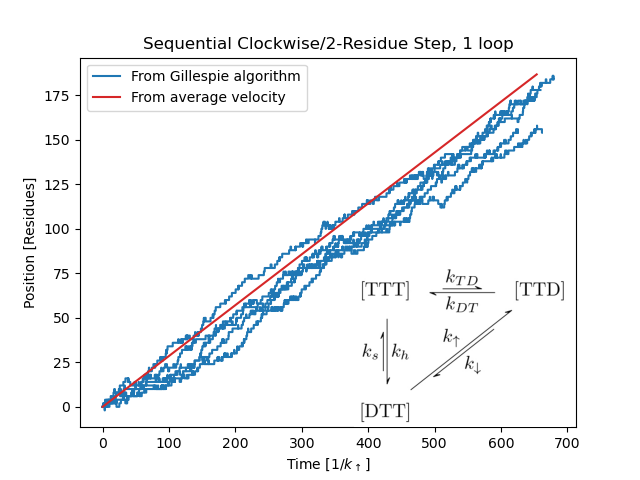

In [4]:
SC_2R_1_loop = SC2R1Loop()
trajectories = SC_2R_1_loop.gillespie(n_simulations=5, 
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_1_loop.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)
plt.show()

### 2 loops

![](SC_2R_2_different_loops_kinetic_scheme.jpg)

TODO create image

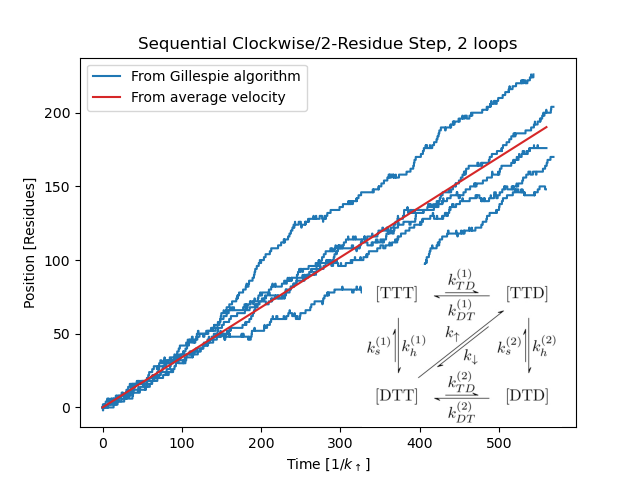

In [5]:
SC_2R_2_loops = SC2R2Loops()
trajectories = SC_2R_2_loops.gillespie(n_simulations=5,
    cumulative_sums=['position', 'ATP'])
ax = SC_2R_2_loops.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_\uparrow$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 2 loops"
)
plt.show()

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

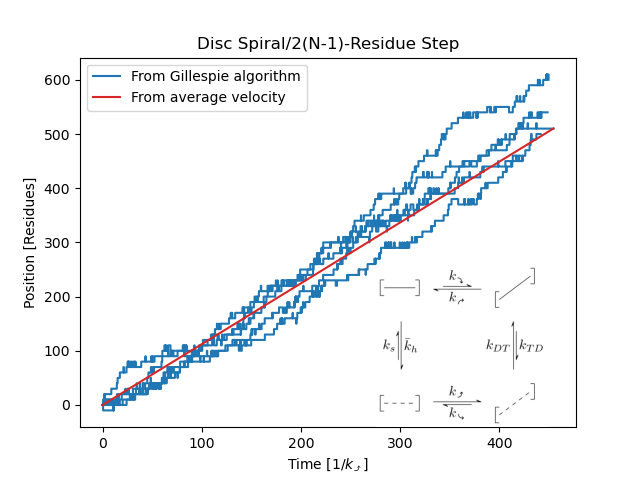

In [6]:
disc_spiral = DiscSpiral()
trajectories = disc_spiral.gillespie(n_simulations=5,
    cumulative_sums={'position': 'displacement', 'ATP': 'ATP'})
ax = disc_spiral.plot_position_evolution(
    list(trajectory[['timestamp', 'position']] for trajectory in trajectories),
    time_unit=r"$1/k_⤴$", 
    position_unit="Residues", 
    kinetic_scheme_image_path="Disc_spiral_kinetic_scheme.jpg",
    title="Disc Spiral/2(N-1)-Residue Step"
)
plt.show()

# Experiments

## Relation between ATP/ADP concentrations ratio and velocity

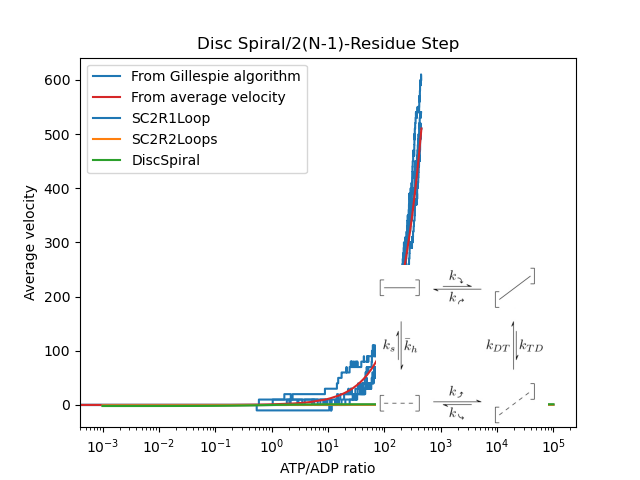

In [7]:
models = [SC2R1Loop(), SC2R2Loops(), DiscSpiral()]
ratios = np.logspace(-3, 5, 100) * SC_2R_1_loop.equilibrium_ATP_ADP_ratio
velocities = {model: [] for model in models}
for ratio in ratios:
    for model in models:
        model.ATP_ADP_ratio = ratio
        velocities[model].append(model.average_velocity())

for model in models:
    plt.plot(ratios, velocities[model], label=model.__class__.__name__)
plt.xscale('log')
plt.xlabel("ATP/ADP ratio")
plt.ylabel("Average velocity")
plt.legend()
plt.show()

## Sequential Clockwise/2-Residue Step, comparison between 1 and 2 loops

In [8]:
# 1 loop and 2 loops models
SC_2R_1_loop = SC2R1Loop()
SC_2R_2_loops = SC2R2Loops()

ATP_ADP_ratios = np.logspace(-1, 1, 10)
for ATP_ADP_ratio in ATP_ADP_ratios:
    print("ATP/ADP:", ATP_ADP_ratio)
    SC_2R_1_loop.ATP_ADP_ratio = ATP_ADP_ratio
    SC_2R_2_loops.ATP_ADP_ratio = ATP_ADP_ratio
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_1_loop.kinetic_scheme.nodes(data=True)})
    print({node: attributes['probability']() 
           for node, attributes 
           in SC_2R_2_loops.kinetic_scheme.nodes(data=True)})



ATP/ADP: 0.1
{'TTT': 0.08333333333333333, 'DTT': 0.33333333333333337, 'TTD': 0.5833333333333334}
{'TTT': 0.03736263736263736, 'DTT': 0.07692307692307691, 'TTD': 0.33406593406593404, 'DTD': 0.5516483516483516}
ATP/ADP: 0.16681005372000587
{'TTT': 0.12508063787386262, 'DTT': 0.3333333333333333, 'TTD': 0.541586028792804}
{'TTT': 0.06285529607164458, 'DTT': 0.11117482042019278, 'TTD': 0.3284880760923012, 'DTD': 0.4974818074158614}
ATP/ADP: 0.2782559402207124
{'TTT': 0.17876891510895462, 'DTT': 0.3333333333333333, 'TTD': 0.48789775155771203}
{'TTT': 0.10180497553128667, 'DTT': 0.15165730349483372, 'TTD': 0.31601578414408676, 'DTD': 0.43052193682979273}
ATP/ADP: 0.46415888336127786
{'TTT': 0.24070663630827838, 'DTT': 0.33333333333333326, 'TTD': 0.4259600303583882}
{'TTT': 0.1549318394055542, 'DTT': 0.1940076963112737, 'TTD': 0.2947146725000551, 'DTD': 0.356345791783117}
ATP/ADP: 0.774263682681127
{'TTT': 0.30380826716022774, 'DTT': 0.3333333333333333, 'TTD': 0.3628583995064389}
{'TTT': 0.217

## Add potential

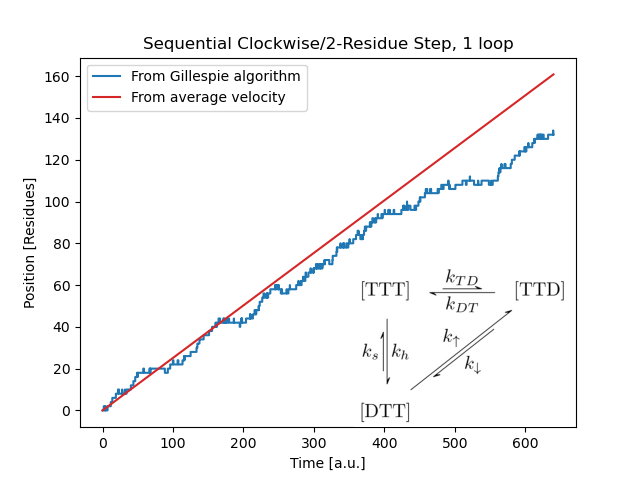

In [9]:
# If positive, potential increases when chaperone goes up, i.e. it favors going
# down.
potential_over_temperature = 0.1
SC_2R_1_loop = SC2R1Loop()
for _, _, attributes in SC_2R_1_loop.kinetic_scheme.edges(data=True):
    if 'position' in attributes and attributes['position'] > 0:
        old_rate = attributes['rate']
        attributes['rate'] = (
            lambda old_rate=old_rate: 
                old_rate() * np.exp(-potential_over_temperature))
    elif 'position' in attributes and attributes['position'] < 0:
        old_rate = attributes['rate']
        attributes['rate'] = (
            lambda old_rate=old_rate: 
                old_rate() * np.exp(potential_over_temperature))

SC_2R_1_loop_position = SC_2R_1_loop.gillespie(
    n_steps=1000, 
    n_simulations=1, 
    cumulative_sums={'position': 'displacement'})

ax = SC_2R_1_loop.plot_position_evolution(
    SC_2R_1_loop_position[['timestamp', 'position']],
    time_unit=r"a.u.", 
    position_unit="Residues", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2-Residue Step, 1 loop"
)

## Defective protomer

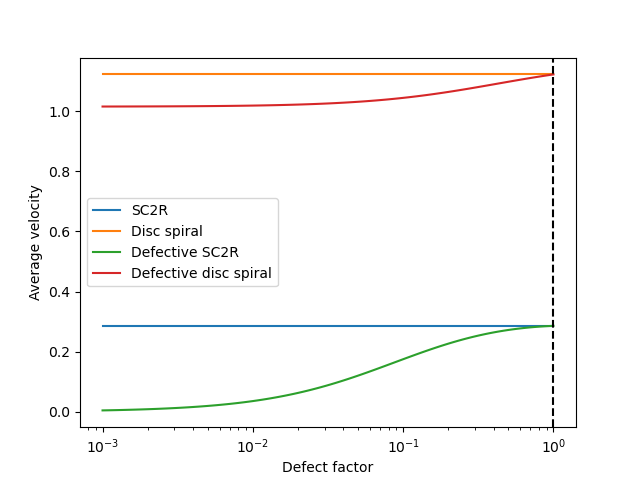

Max velocity for SC2R: 0.2857142857142857
Max velocity for Disc spiral: 1.122661122661123
Max velocity for Defective SC2R: 0.28571428571428586
Max velocity for Defective disc spiral: 1.1226611226611232


In [10]:
sc2r = SC2R1Loop()
defective_sc2r = DefectiveSC2R()
disc_spiral = DiscSpiral()
defective_disc_spiral = DefectiveDiscSpiral()

defect_factors = np.logspace(-3, 0, 100)
velocities = {
    'SC2R': [],
    'Disc spiral': [],
    'Defective SC2R': [],
    'Defective disc spiral': [],
}
for defect_factor in defect_factors:
    defective_sc2r.defect_factor = defect_factor
    defective_disc_spiral.defect_factor = defect_factor
    velocities['SC2R'].append(sc2r.average_velocity())
    velocities['Disc spiral'].append(disc_spiral.average_velocity())
    velocities['Defective SC2R'].append(defective_sc2r.average_velocity())
    velocities['Defective disc spiral'].append(
        defective_disc_spiral.average_velocity())

fig, ax = plt.subplots()
for model in velocities:
    ax.plot(defect_factors, velocities[model], label=model)
ax.axvline(1, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel("Defect factor")
ax.set_ylabel("Average velocity")
ax.legend()
plt.show()
# print max velocity
print("Max velocity for SC2R:", max(velocities['SC2R']))
print("Max velocity for Disc spiral:", max(velocities['Disc spiral']))
print("Max velocity for Defective SC2R:", max(velocities['Defective SC2R']))
print("Max velocity for Defective disc spiral:", 
      max(velocities['Defective disc spiral']))


# Test interactivity

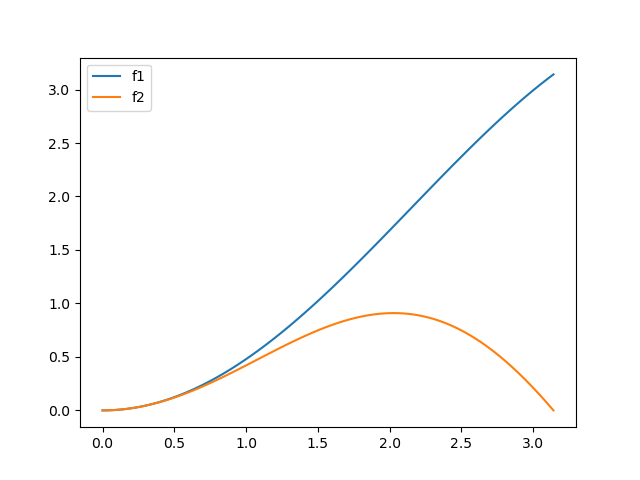

In [11]:
import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, np.pi, 100)
tau = np.linspace(0.5, 10, 100)

def f1(x, tau, beta):
    return np.sin(x * tau) * x * beta
def f2(x, tau, beta):
    return np.sin(x * beta) * x * tau


fig, ax = plt.subplots()
controls = iplt.plot(x, f1, tau=tau, beta=(1, 10, 100), label="f1")
iplt.plot(x, f2, controls=controls, label="f2")
_ = plt.legend()
plt.show()

In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [21]:
sc2r = SC2R1Loop()
box = widgets.FloatText(
    value=1,
    description=r'\(k_\uparrow\):',
    #disabled=False
)
slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=10.0,
    step=0.1,
    description=r'slider',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def update_k_up(k_up: float):
    sc2r.k_up = k_up
    box.value = sc2r.k_up
interact(update_k_up, k_up=slider)
#out = widgets.HBox([box])
display(slider)
#display(out)
display(box)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='slider', max=10.0, readout_…

FloatSlider(value=1.0, continuous_update=False, description='slider', max=10.0, readout_format='.1f')

FloatText(value=1.0, description='\\(k_\\uparrow\\):')

In [14]:
from ipywidgets import GridspecLayout, Button, Layout
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(4, 3, height='300px')
grid[:3, 1:] = create_expanded_button('One', 'success')
grid[:, 0] = create_expanded_button('Two', 'info')
grid[3, 1] = create_expanded_button('Three', 'warning')
grid[3, 2] = create_expanded_button('Four', 'danger')
grid

GridspecLayout(children=(Button(button_style='success', description='One', layout=Layout(grid_area='widget001'…

In [6]:
from ipywidgets import GridspecLayout, FloatText, Label, HTMLMath
from ipywidgets import Label

def add_parameter(
        grid: GridspecLayout,
        row: int,
        symbol: str,
        desc: str,
        value: float = 1.0
):
    grid[row, 0] = HTMLMath(value=symbol)
    grid[row, 1] = FloatText(value=value)
    grid[row, 2] = Label(value=desc)

grid = GridspecLayout(8, 3, height='300px')
grid[0, :] = Label(value="General physical parameters")
add_parameter(grid, 1, r"$\frac{[\text{ATP}]}{[\text{ADP}]}\Bigr|_\text{eq.}$",
              "Equilibrium ATP/ADP concentration ratio")
add_parameter(grid, 2, r"$K_d^\text{ATP}$", 
              "Protomer-ATP dissociation constant")
add_parameter(grid, 3, r"$K_d^\text{ADP}$",
              "Protomer-ADP dissociation constant")
add_parameter(grid, 4, r"$k_{DT}$", "Effective ADP->ATP exchange rate")
add_parameter(grid, 5, r"$k_{TD}$", "Effective ATP->ADP exchange rate")
add_parameter(grid, 6, r"$k_h$", "ATP hydrolysis rate")
add_parameter(grid, 7, r"$k_s$", "ATP synthesis rate")
display(grid)


display(widgets.Box([Label(value=str(grid[2, 1].value))]))
display(widgets.Box([Label(value="test")]))


GridspecLayout(children=(Label(value='General physical parameters', layout=Layout(grid_area='widget001')), HTM…

Box(children=(Label(value='1.0'),))

Box(children=(Label(value='test'),))

In [55]:
# Get FloatText widget, not value
for e in grid.children:
    print(e)

Label(value='General physical parameters', layout=Layout(grid_area='widget001'))
HTMLMath(value='$\\frac{[\\text{ATP}]}{[\\text{ADP}]}\\Bigr|_\\text{eq.}$', layout=Layout(grid_area='widget002'))
FloatText(value=1.0, layout=Layout(grid_area='widget003'))
Label(value='Equilibrium ATP/ADP concentration ratio', layout=Layout(grid_area='widget004'))
HTMLMath(value='$K_d^\\text{ATP}$', layout=Layout(grid_area='widget005'))
FloatText(value=1.0, layout=Layout(grid_area='widget006'))
Label(value='Protomer-ATP dissociation constant', layout=Layout(grid_area='widget007'))
HTMLMath(value='$K_d^\\text{ADP}$', layout=Layout(grid_area='widget008'))
FloatText(value=1.0, layout=Layout(grid_area='widget009'))
Label(value='Protomer-ADP dissociation constant', layout=Layout(grid_area='widget010'))
HTMLMath(value='$k_{DT}$', layout=Layout(grid_area='widget011'))
FloatText(value=1.0, layout=Layout(grid_area='widget012'))
Label(value='Effective ADP->ATP exchange rate', layout=Layout(grid_area='widget013'))
H

In [25]:
a = widgets.IntSlider()
b = grid.children[2] # widgets.IntSlider()
x = widgets.IntSlider()
ui = widgets.HBox([a, b, x])
def f(a, b, c):
    print((a, b, c))
    print(a + b + c)

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': x})

display(ui, out)

Output()